In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from math import isnan
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, log_loss
from sklearn.naive_bayes import GaussianNB
%matplotlib inline


 ### Функции
 

In [2]:
def calc_metrcis(X_test,y_test,clf):
    preds = clf.predict(X_test)
    probas = clf.predict_proba(X_test)
    metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
    metrics['f1-score'] = f1_score(y_test, preds)
    metrics['precision'] = precision_score(y_test, preds)
    metrics['recall'] = recall_score(y_test, preds)
    metrics['ROC-AUC'] = roc_auc_score(y_test,probas[:,1])
    metrics['log_loss'] = log_loss(y_test,probas)
    return metrics

In [3]:
def draw_roc_auc(X_test,y_test,clf):
    fpr, tpr, thresholds = get_roc_curve(model=clf, 
              data=Pool(X_test,y_test), 
              thread_count=4, 
              plot=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(fpr,fpr,'--')
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label=f'ROC-AUC: {roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]):.3f}')
    plt.grid(True)
    plt.show()

In [4]:
def prepare_dataframe(folder,course_id,subject=None):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved, 
                                    size_of_answer, size_of_review, rewiew_time, course_element_id
                                    id from solution_log
    """
    if subject is None:
        path = f'{folder}/{course_id}/'
    else:
        path = f'{folder}/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
    
    
    solution_log['size_of_answer'] = solution_log['users_answer'].apply(lambda x: len(str(x)))
    solution_log['size_of_review'] = solution_log['review'].apply(lambda x: len(str(x)))

    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff', 'size_of_answer', 'size_of_review', 'tries_count', 'review_time']]
    pre_df['id_from_sl'] = solution_log['id']
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    ##pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id', 'course_element_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','is_achieved']]
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id').drop(columns='id')
    return df
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

In [5]:

def me_grid_search(grid,model,df,test_size = 0.2, cv=5, plot=True):
    X = df.drop(columns=['user_id','is_achieved_max'])
    y = df['is_achieved_max'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=test_size)
    model.grid_search(param_grid=grid,X=X_train,y=y_train, search_by_train_test_split=False, cv=cv, plot=plot,verbose=False)
    display(model.get_feature_importance(prettified=True).head(10))
    calc_metrcis(X_test,y_test, model)
    draw_roc_auc(X_test,y_test, model)
    return metrics, model

## Новые + первоначальные

In [6]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
df = df.sort_values(by = ['user_id', 'review_time'])
def q_9(x):
    return np.quantile(x, 0.9) 
q_9.__name__ = '0.9 quantile'
df1 = df.groupby(['user_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df1.columns = ['_'.join(col) for col in df1.columns]
df1.reset_index(inplace=True)
df['less_48'] = df['hours_diff']<48
gdf = df.groupby('user_id').agg({'less_48':'sum','id_from_sl':'count'})
gdf['in_df'] = gdf['less_48']/gdf['id_from_sl'] >= 0.9
valid_indices = gdf[gdf['in_df']].index
df_for_train_new_actual = df1[df1.user_id.isin(valid_indices.values)]

In [7]:
df_for_train_new_actual[df_for_train_new_actual['size_of_answer_std'].isna()]

,user_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
12,100119920110029719,1.0,1.0,1.0,1,NaN,1,133.0,NaN,310.0,NaN,0
13,100119930111128631,45.0,45.0,45.0,45,NaN,45,116.0,NaN,95.0,NaN,0
16,100119970110112023,0.0,0.0,0.0,0,NaN,0,66.0,NaN,34.0,NaN,0
42,100120030110755270,4.0,4.0,4.0,4,NaN,4,90.0,NaN,34.0,NaN,0
82,100120040110045553,24.0,24.0,24.0,24,NaN,24,90.0,NaN,1357.0,NaN,0
93,100120040110088198,1.0,1.0,1.0,1,NaN,1,1735.0,NaN,34.0,NaN,0
105,100120040110279406,42.0,42.0,42.0,42,NaN,42,90.0,NaN,85.0,NaN,0
116,100120040110598026,18.0,18.0,18.0,18,NaN,18,134.0,NaN,941.0,NaN,0
174,100120050110018111,25.0,25.0,25.0,25,NaN,25,579.0,NaN,147.0,NaN,0
193,100120050110053225,43.0,43.0,43.0,43,NaN,43,196.0,NaN,34.0,NaN,0


In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
df_for_train_new_actual.dropna(inplace=True)
df_for_train_new_actual['is_achieved_max'].sum()/df_for_train_new_actual.shape[0]

0.39457831325301207

In [10]:
X = df_for_train_new_actual.drop(columns=['user_id','is_achieved_max'])
y = df_for_train_new_actual['is_achieved_max'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [11]:
preds = np.ones(X_test.shape[0])
probas = np.ones(X_test.shape[0])
constant_metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
constant_metrics['f1-score'] = f1_score(y_test, preds)
constant_metrics['precision'] = precision_score(y_test, preds)
constant_metrics['recall'] = recall_score(y_test, preds)
constant_metrics['ROC-AUC'] = roc_auc_score(y_test,probas)
constant_metrics['log_loss'] = log_loss(y_test,probas)
constant_metrics 

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.574468,0.402985,1.0,0.5,20.620642


In [12]:
clf = RandomForestClassifier(75, random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=75, random_state=42)

In [13]:
rf_metrcis = calc_metrcis(X_test,y_test,clf)
rf_metrcis

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.625,0.714286,0.555556,0.789815,0.534929


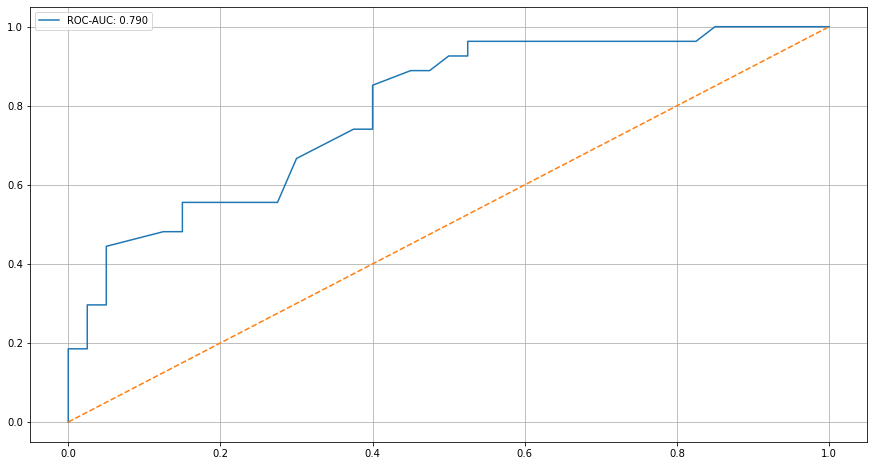

In [14]:
y_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr,label=f'ROC-AUC: {roc_auc_score(y_test, y_proba[:,1]):.3f}')
plt.plot(fpr, fpr, '--')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
g_clf = GaussianNB()
g_clf.fit(X_train,y_train)

GaussianNB()

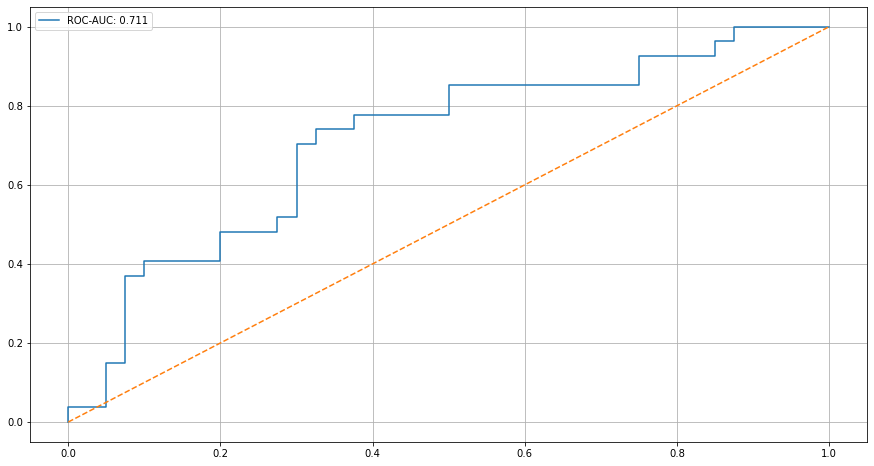

In [16]:
y_proba = g_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr,label=f'ROC-AUC: {roc_auc_score(y_test, y_proba[:,1]):.3f}')
plt.plot(fpr, fpr, '--')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
gb_metrics = calc_metrcis(X_test,y_test,g_clf)
gb_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.621622,0.489362,0.851852,0.711111,1.74894


In [18]:
default_cat = CatBoostClassifier(random_seed=42,
                                custom_metric=['Precision','Recall'],
                                 early_stopping_rounds=75)
default_cat.fit(X_train,y_train,eval_set=(X_test,y_test),logging_level='Silent',plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

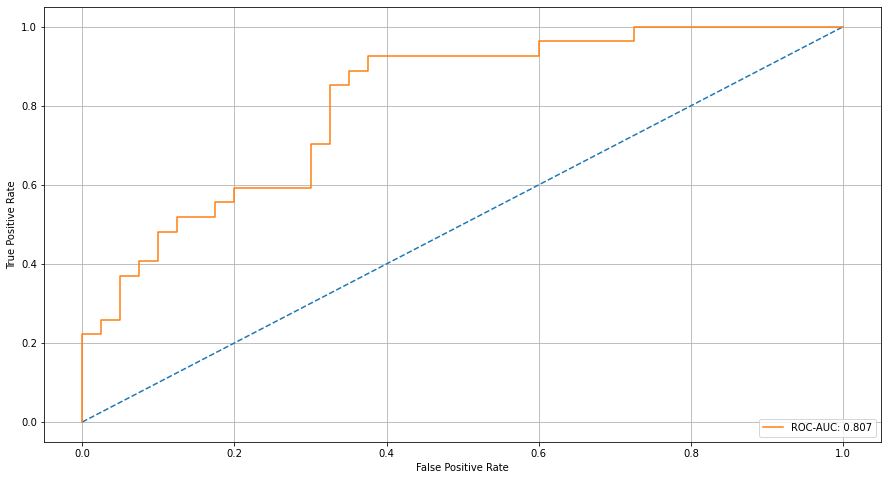

In [19]:
draw_roc_auc(X_test,y_test,default_cat)

In [20]:
default_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours_diff_max,12.232954
1,hours_diff_min,12.167487
2,size_of_review_std,11.293262
3,size_of_answer_mean,11.196294
4,hours_diff_std,11.088768
5,size_of_review_mean,10.584857
6,size_of_answer_std,9.405516
7,hours_diff_mean,7.612593
8,hours_diff_0.9 quantile,7.283090
9,hours_diff_median,7.135178


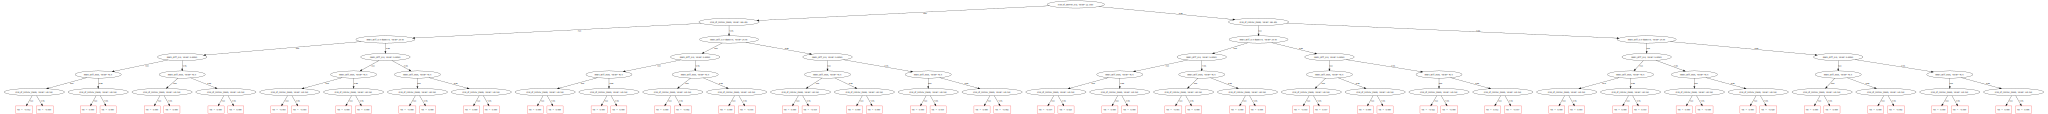

In [26]:
import graphviz
pool = Pool(X, y, feature_names=list(X.columns))
default_cat.plot_tree(322, pool)

In [274]:
default_cat_metrics = calc_metrcis(X_test, y_test, default_cat)
default_cat_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.627451,0.666667,0.592593,0.807407,0.514038


In [ ]:
default_cat.save_model('cat_classifier.pkl')

In [311]:
total = pd.concat([constant_metrics,gb_metrics, rf_metrcis, default_cat_metrics],ignore_index=True)
total.rename({0:'Constant',1:'GaussianNB',2:'Random Forest',3:'CatBoost'}, axis='index')

,f1-score,precision,recall,ROC-AUC,log_loss
Constant,0.574468,0.402985,1.000000,0.500000,20.620642
GaussianNB,0.621622,0.489362,0.851852,0.711111,1.748940
Random Forest,0.625000,0.714286,0.555556,0.789815,0.534929
CatBoost,0.627451,0.666667,0.592593,0.807407,0.514038


In [161]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
old_courses = [7,6,23,24,25,26,27,28,29,30,31,32,33,36,40,41,42,45,48,49,50,52,53,54,60]
for ID in old_courses:
    tmp_df = prepare_dataframe(folder='old_courses_with_manual_check',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
df = df.sort_values(by = ['user_id', 'review_time'])
df2 = df.groupby(['user_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df2.columns = ['_'.join(col) for col in df2.columns]
df2.reset_index(inplace=True)
df['less_48'] = df['hours_diff']<48
gdf = df.groupby('user_id').agg({'less_48':'sum','id_from_sl':'count'})
gdf['in_df'] = gdf['less_48']/gdf['id_from_sl'] >= 0.9
valid_indices = gdf[gdf['in_df']].index
df_for_train_all = df2[df2.user_id.isin(valid_indices.values)]

In [162]:
old_cat = CatBoostClassifier(iterations=500,
                    custom_metric=['F1','Precision','Recall']
                    ,random_seed=42
                    ,early_stopping_rounds=75
                    ,loss_function='Logloss'
                    ,verbose=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detector  (75 iterations wait)
Stopped by overfitting detec

,Feature Id,Importances
0,hours_diff_max,21.511913
1,hours_diff_std,14.999515
2,size_of_review_mean,9.775117
3,hours_diff_mean,9.709211
4,hours_diff_0.9 quantile,9.702994
5,size_of_answer_mean,9.367431
6,size_of_review_std,9.025274
7,hours_diff_min,7.825022
8,size_of_answer_std,4.466810
9,hours_diff_median,3.616712


,f1-score,precision,recall,ROC-AUC,log_loss
0,0.60274,0.666667,0.55,0.817434,0.780812


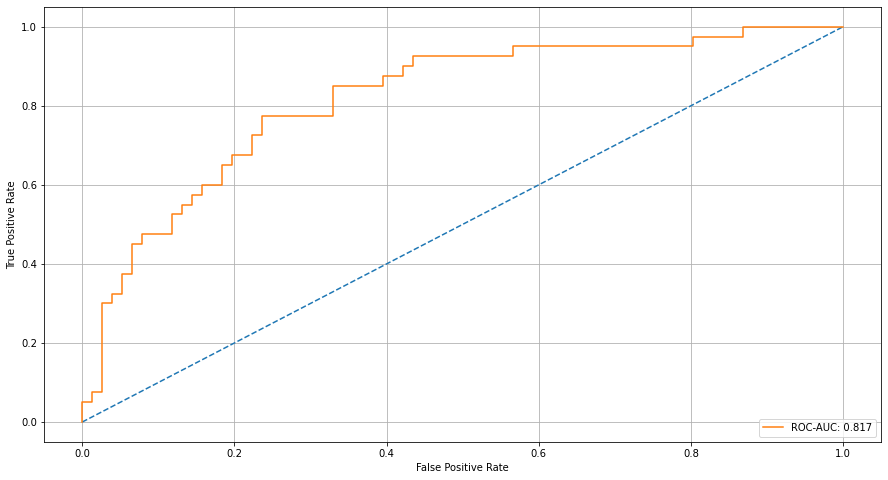

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.60274,0.666667,0.55,0.817434,0.780812


In [165]:
me_grid_search(grid,old_cat,df_for_train_all)

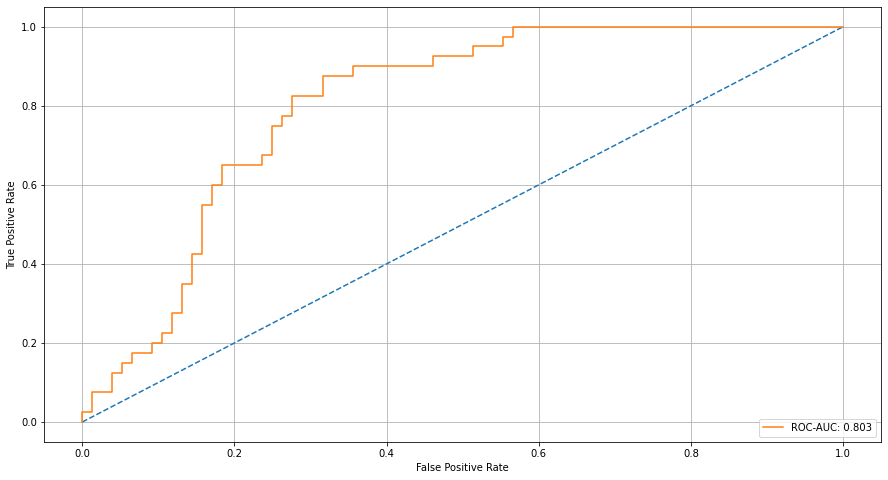

In [92]:
fpr, tpr, thresholds = get_roc_curve(model=new_cat, 
              data=Pool(X_test,y_test), 
              thread_count=4, 
              plot=False)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(fpr,fpr,'--')
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label=f'ROC-AUC: {roc_auc_score(y_test,new_cat.predict_proba(X_test)[:,1]):.3f}')
plt.grid(True)
plt.show()

In [190]:

preds = CatBoostClassifier().load_model('cat_classifier.pkl').predict(X_test)
probas = CatBoostClassifier().load_model('cat_classifier.pkl').predict_proba(X_test)
metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
metrics['f1-score'] = f1_score(y_test, preds)
metrics['precision'] = precision_score(y_test, preds)
metrics['recall'] = recall_score(y_test, preds)
metrics['ROC-AUC'] = roc_auc_score(y_test,probas[:,1])
metrics['log_loss'] = log_loss(y_test,probas)
display(metrics)

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.961538,1.0,0.925926,0.97963,0.117648


In [ ]:
CatBoostClassifier().load_model('cat_classifier.pkl').sh

In [192]:

preds = CatBoostClassifier().load_model('cat_classifier.pkl').predict(X_train)
probas = CatBoostClassifier().load_model('cat_classifier.pkl').predict_proba(X_train)
metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
metrics['f1-score'] = f1_score(y_train, preds)
metrics['precision'] = precision_score(y_train, preds)
metrics['recall'] = recall_score(y_train, preds)
metrics['ROC-AUC'] = roc_auc_score(y_train,probas[:,1])
metrics['log_loss'] = log_loss(y_train,probas)
display(metrics)

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.914286,0.90566,0.923077,0.958075,0.241458
